In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
# move to root directory
while os.path.basename(os.getcwd()) != "reward-network-iii":
    os.chdir("..")

In [4]:
files = [
    'data/24_02_04/model/mode_nodes_more_steps_0.csv',
    'data/24_02_04/model/mode_nodes_more_steps_1.csv',
    'data/24_02_04/model/mode_nodes_more_steps_2.csv',
]

dfs = []
for s, file in enumerate(files):
    df = pd.read_csv(file)
    df['seed'] = s
    dfs.append(df)
df = pd.concat(dfs)

In [5]:
df[['average reward', 'average level']] = df[['test_avg_reward_all_envs', 'test_avg_level_all_envs']]

In [6]:
df = df[['episode', 'seed', 'average reward', 'average level']]
df = df.dropna()
df['seed'] = df['seed'].astype(str)

In [7]:
df_myopic = pd.read_json('data/23_11_30/solution_test__myopic.json')
df_random = pd.read_json('data/23_11_30/solution_test__random.json')
df_take_loss = pd.read_json('data/23_11_30/solution_test__take_loss.json')


ref_max_level = {
    'myopic': df_myopic['max_level'].mean(),
    'random': df_random['max_level'].mean(),
    'take_loss': df_take_loss['max_level'].mean(),
}
ref_total_reward = {
    'myopic': df_myopic['total_reward'].mean(),
    'random': df_random['total_reward'].mean(),
    'take_loss': df_take_loss['total_reward'].mean(),
}

In [8]:
# smooth the data group by seed
df = df.groupby('seed').rolling(10, center=True).mean().reset_index()
df = df.dropna()

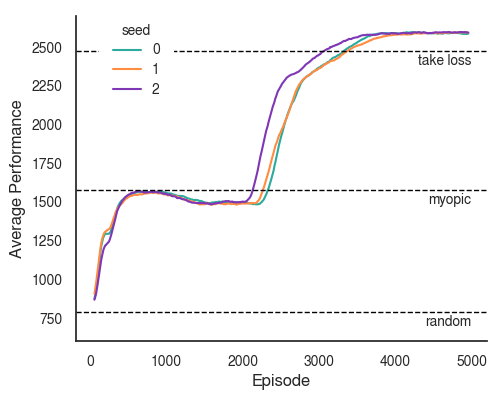

In [82]:
fig = plt.figure(figsize=(5, 4))


ax = plt.subplot()

sns.set_theme(style='white', rc={'font.family': 'serif', 'font.serif': ['Times', 'Times New Roman', 'FreeSans']})


# custom_palette = ['#1b9e77', '#d95f02', '#7570b3']
custom_palette = ['#2BAA9D', '#FF8C41', '#7F37B6', ]


sns.lineplot(data=df, x="episode", y="average reward", hue="seed", palette=custom_palette, ax=ax)

legend = ax.legend(frameon=True, fontsize=10, title='seed', title_fontsize=10, loc='upper left', bbox_to_anchor=(0.04, 1.04), facecolor='white', borderpad=1, labelspacing=0.4)
legend.get_frame().set_alpha(1)  
legend.get_frame().set_edgecolor('none')

plt.axhline(ref_total_reward['myopic'], ls='--', label='myopic', color='black', lw=1)
plt.text(5000, ref_total_reward['myopic'] - 20, 'myopic', ha='right', va='top', fontsize=10)
plt.axhline(ref_total_reward['random'], ls='--', label='random', color='black', lw=1)
plt.text(5000, ref_total_reward['random'] - 20, 'random', ha='right', va='top', fontsize=10)
plt.axhline(ref_total_reward['take_loss'], ls='--', label='take loss', color='black', lw=1)
plt.text(5000, ref_total_reward['take_loss'] - 20, 'take loss', ha='right', va='top', fontsize=10)

plt.ylim(600, 2700)




ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Average Performance', fontsize=12)


folder = os.path.join('analysis','plots', 'algorithm')

os.makedirs(folder, exist_ok=True)

png_filename = os.path.join(folder,'algorithm.png')
pdf_filename = os.path.join(folder,'algorithm.pdf')

plt.tight_layout()
fig.subplots_adjust(top=0.98, right=0.99)
plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

Text(5000, 2.885, 'take loss')

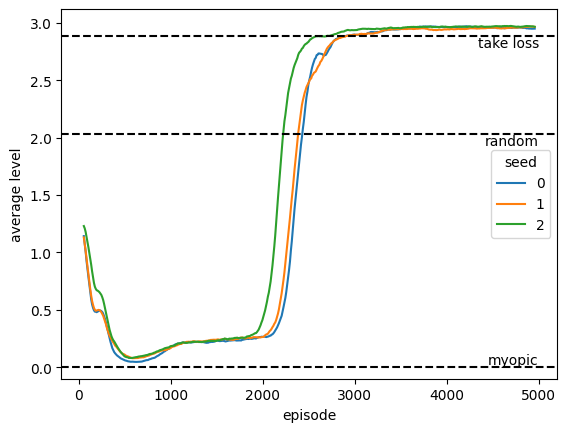

In [10]:
sns.lineplot(data=df, x="episode", y="average level", hue="seed")
plt.axhline(ref_max_level['myopic'], ls='--', label='myopic', color='black')
plt.text(5000, ref_max_level['myopic'], 'myopic', ha='right', va='bottom')
plt.axhline(ref_max_level['random'], ls='--', label='random', color='black')
plt.text(5000, ref_max_level['random'], 'random', ha='right', va='top')
plt.axhline(ref_max_level['take_loss'], ls='--', label='take loss', color='black')
plt.text(5000, ref_max_level['take_loss'], 'take loss', ha='right', va='top')

In [11]:
# each run toook 5 min on a RTX 5000
# In this time the algorithm played tested 5000 different solutions each on 1000 different networks.